In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from csv import writer 
import math
from scipy.interpolate import interp1d
import numpy as np
import os
import astropy.units as u

from scipy import optimize
import corner
import radvel
import radvel.likelihood
from radvel.plot import orbit_plots, mcmc_plots

/Users/emmaturtelboom/opt/anaconda3/envs/py38/lib/python3.8/site-packages/radvel/gp.py:32: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  warnings.warn("celerite not installed. GP kernals using celerite will not work. \


In [2]:
#planet class that inherits the values from the target class
#reads in data file about the planet information 
class Planet(): 
    def __init__(self, PlanetID, Period, Eccentricity, Mplanet, Tc, K=None): 
        
        self.PlanetID = PlanetID
        self.Mplanet = Mplanet
        self.Eccentricity = Eccentricity
        self.Period = Period
        self.Tc = Tc
        self.K = K
        
    #defining what the name of the class is when an object created is called   
    def __repr__(self):
        return 'Planet Class'

In [3]:
#Target class loads in system data, gets attributes for multiple planets, and gets data about previous rv data
class Target(): 
    #needs a file for the target info and optional previous RV data
    #user will have to enter in telescope 
    def __init__(self, file, telescope, prev_rv_data = None): 
        #inherits planet class and creates empty array so that planet info will be stored
        self.Planets = []
        self.file = file
        
        #opens the file and reads it in 
        target_file = pd.read_csv(self.file, header = 0)
        ID = target_file['ID'][0]
        Mstar = target_file['Mstar'][0]
        
        self.ID = ID
        self.Mstar = Mstar
        self.prev_rv_data = None
        self.no_pl = 0
        self.telescope = telescope
        #if user has previous RV data
        if prev_rv_data != None:
            #reads in previous rv data and assigns them variables
            #these will be used to create plots
            file_prev_rv = pd.read_csv(prev_rv_data, header = 1)
            self.file_prev_rv = file_prev_rv
            self.prev_rv_data = True

            prev_rv_jd = file_prev_rv['JD']
            prev_rv_rv = file_prev_rv['RV']
            prev_rv_err = file_prev_rv['Error']
            prev_telescope = file_prev_rv['tel']

            self.prev_rv_jd = prev_rv_jd
            self.prev_rv_rv = prev_rv_rv
            self.prev_rv_err = prev_rv_err
            self.prev_telescope = prev_telescope
            
    #defining what the name of the class is when an object created is called               
    def __repr__(self):
        return 'Target Class:'#, self.Target.ID

    #creating a function that creates multiple objects of the planet class to create multiple planets
    #this will be read in by the csv file provided into the planet class
    def load_planets(self, planet_file):

        #reading in the planet file and assigning it variable data 
        data_pl = pd.read_csv(planet_file, header = 0)
        
        no_pl = len(data_pl)
        self.no_pl = no_pl

        for i in range(self.no_pl):
            #subset of file will be the ith row that is iterated 
            subset = data_pl.iloc[i]
            
            #getting the values from the file for each planet in the system 
            planetID = subset['PlanetID']
            mplanet = subset['MPlanet']
            eccentricity = float(subset['Eccentricity'])
            period = float(subset['Period'])
            #tc = time of transit
            tc = float(subset['tc'])

            #creating individual objects for each planet and adding them to the list as defined in __init__
            planet = Planet(planetID, period, eccentricity, mplanet, tc)
            self.Planets.append(planet)

In [4]:
#square root of G
G_sqrt = 28.4329

#mass of Jupiter in grams
M_J = 1.899 * 10**30

#mass of Sun in grams 
M_sun = 1.989*10**33

#year in seconds
yr = 3.154*10**7 

In [317]:
#creates the plots and the simulated data points
class RV_obs(Target): 
    def __init__(self, Target, t_obs, t_end, No_obs, t_ref): 
        self.Target = Target
        self.t_obs = t_obs
        self.t_end = t_end
        self.No_obs = No_obs
        self.t_ref = t_ref
    
    
    #generates the times that the user will be observing over
    #user must enter in the time they are planning on starting to observe and the date they want to end 
    #they also have to add the number of observations to establish the cadence 
    #for now we are assuming an equal cadence rather than a random one 
    def Generate_times(self): 
        times = np.linspace(self.t_obs, self.t_end, self.No_obs)
        self.times = times
        return self.times
    
    #K value is the semi amplitude of the sin curve that will be generated from the RV data
    def K_value(self, times, planet, star): 
        #takes from the planet class to calculate the K value
        print (planet.Eccentricity, planet.Mplanet)
        K = G_sqrt / (np.sqrt(1 - planet.Eccentricity**2)) * (planet.Mplanet*u.M_earth / u.M_earth) * \
        (star.Mstar*u.M_sun / u.M_sun)**(-2/3) * (planet.Period*u.yr / u.yr)**(-1/3)
        planet.K = K
        return planet.K 
    
    #creates the RV values that will be put into the RV plot
    def sim_RVs(self, noise = 0): 
        times = self.Generate_times()
        Star = self.Target
        RVs = []
        RV_values = 0
        #come back to this later when we can create errors
        self.RV_errs = np.array([10]*len(times))
        #this is to make sure that we get multiple RV data points for multiple planets for more than one planet
        #loops through the number of planets and goes into the Planet class to get the data 
        for planet in Star.Planets: 
            K = self.K_value(times, planet, Star)
            print(K)
            #takes from the planet class and the K_value class to calculate the RV data point
            RV_pl = -K*np.sin(2*np.pi*(times - self.t_ref)/planet.Period) + noise*np.random.randn(len(times))
            #adds RVs for every planet together 
            RV_values += RV_pl
            #all RVs is the final RV
            self.RV_values = RV_values
            
        return self.RV_values
    
    #plots the RV data created from the previous function
    def RV_plot(self, mode = 'sim'): 
        #simulated data is plotted
        if mode == 'sim': 
            fig = plt.figure()
            plt.scatter(self.times, self.RV_values)
            plt.xlabel('Time (JD)')
            plt.ylabel('RV')
            plt.title("Simulated Data")
            self.fig = fig
            return self.fig
        #previous data loaded in from Target class is plotted
        elif mode == 'prev': 
            fig = plt.figure()
            plt.scatter(self.Target.prev_rv_jd, self.Target.prev_rv_rv)
            plt.xlabel('Time (JD)')
            plt.ylabel('RV')
            plt.title("Previous RV Data")
            self.fig = fig
            return self.fig
        #both simulated data and previous data are plotted
        elif mode == 'both': 
            fig = plt.figure()
            plt.scatter(self.Target.prev_rv_jd, self.Target.prev_rv_rv, label = 'previous RV')
            plt.scatter(self.times, self.RV_values, label = 'simulated')
            plt.xlabel('Time (JD)')
            plt.ylabel('RV')
            plt.legend()
            self.fig = fig
            return self.fig
        
    #creating function for the parameters
    #parameters to vary is by default an empty list, if user wants to input parameters to vary then they will have to 
    #define it when they call this function 
    def parameters(self, params_to_vary = []): 
        #need a parameter for each planet so I am looping through how many planets there are and then 
        #adding those values to the parameter values 
        #defining the basis for the parameter values 
        Star = self.Target
        no_pl = self.Target.no_pl
        instnames = np.array(Star.telescope)
        
        params = radvel.Parameters(no_pl, basis='per tc e w k')
        self.params = params
        for i in range(1, no_pl+1): 
            time_base = (self.times.min() + self.times.max())/2
            params[f'per{i}'] = radvel.Parameter(value = Star.Planets[i-1].Period)
            params[f'tc{i}'] = radvel.Parameter(value = Star.Planets[i-1].Tc)
            params[f'e{i}'] = radvel.Parameter(value = Star.Planets[i-1].Eccentricity)
            params[f'w{i}'] = radvel.Parameter(value = np.pi/2)
            params[f'k{i}'] = radvel.Parameter(value = Star.Planets[i-1].K)
        
        
#         params2 = params.basis.to_any_basis(params,'per tc secosw sesinw k')
        mod = radvel.RVModel(params, time_base=time_base)
        print (mod.params)
        mod.params['dvdt'] = radvel.Parameter(value = -0.02)
        mod.params['curv'] = radvel.Parameter(value = 0.01)
        
        like = radvel.likelihood.RVLikelihood(mod, self.times, self.RV_values, self.RV_errs, suffix="_"+Star.telescope)
        #make a set a gamma_prevtelescope and jit_prevtelescope and a set for the simulated telescope
        #get name of telescope used in previous observations and use that to track uncertainty in telescope 
        #do the same for simulated telescope data 
        if self.Target.prev_rv_data != None: 
            like.params[f'gamma_{self.Target.prev_telescope}'] = radvel.Parameter(value = 0.1)
            like.params[f'jit_{self.Target.prev_telescope}'] = radvel.Parameter(value = 1.0)
        like.params[f'gamma_{self.Target.telescope}'] = radvel.Parameter(value=0.1, vary=True)
        like.params[f'jit_{self.Target.telescope}'] = radvel.Parameter(value=1.0, vary=True)
        like = radvel.likelihood.CompositeLikelihood([like])
        
        #for each of the parameters for each planet, set them to vary as true or false
        #want user to pass in a list of parameters they want to vary 
        
        #for loop is for each planet's parameters 
        for i in range(1, no_pl+1): 
            #like.params[f'secosw{i}'].vary = False
            #like.params[f'sesinw{i}'].vary = False
            like.params[f'e{i}'].vary = True
            like.params[f'per{i}'].vary = True
            like.params[f'tc{i}'].vary = True
            like.params[f'k{i}'].vary = True
            like.params[f'w{i}'].vary = False
#         #parameters that are for the previous telescope from previous data and the current Target telescope
        if self.Target.prev_rv_data != None:
            like.params[f'gamma_{self.Target.prev_telescope}'].vary = False
            like.params[f'jit_{self.Target.prev_telescope}'].vary = False
        like.params[f'gamma_{self.Target.telescope}'].vary = False
        like.params[f'jit_{self.Target.telescope}'].vary = False
                
        #looping though array of parameters to vary and setting them equal to true 
        if len(params_to_vary) > 0:
            for i in params_to_vary:
                like.params[params_to_vary[i]].vary = True
            
        '''
        the rest of the code below is from the intro to astro github tutorial/radvel K2-24 tutorial  
        ''' 
        #initializes radvel.Posterior object 
        post = radvel.posterior.Posterior(like)

        # add priors
        for i in range(1, no_pl+1):
            post.priors += [radvel.prior.Gaussian(f'tc{i}', Star.Planets[i-1].Tc, 0.1)]
            post.priors += [radvel.prior.Gaussian(f'per{i}', Star.Planets[i-1].Period, 0.5)]
        post.priors += [radvel.prior.HardBounds(f'jit_{self.Target.telescope}', -20.0, 20.0)]
        post.priors += [radvel.prior.EccentricityPrior(no_pl)]
        
#         print("Initial loglikelihood = %f" % post.logprob())
        print (post.name_vary_params())
    
        # Perform Max-likelihood fitting
        res  = optimize.minimize(
            post.neglogprob_array,
            post.get_vary_params(),
            method='Powell',
            options=dict(maxiter=100000,maxfev=100000,xtol=1e-8)
            )
        print("Final loglikelihood = %f" % post.logprob())
        print (post.name_vary_params())
        print (post)
        
        #ready-made plots that radvel has, from intro to astro tutorial on github
        RVPlot = orbit_plots.MultipanelPlot(post)
        RVPlot.plot_multipanel()
        return RVPlot

In [318]:
class cadence(RV_obs): 
    def __init__(self, RV_obs): 
        self.RV_obs = RV_obs

    #this function will phase fold 
    def phase_fold(self): 
        #converts JD time to orbital phase, taken from radvel docs
        P =  self.RV_obs.Target.Planets[0].Period
        tc =  self.RV_obs.Target.Planets[0].Tc
        t = self.RV_obs.Target.prev_rv_jd
        rv = self.RV_obs.Target.prev_rv_rv
        phase = np.mod(t - tc, P)
        phase /= P
        self.phase = phase
        phase_plot = plt.figure()
        plt.scatter(phase, rv)
        plt.xlabel('Phase')
        plt.ylabel('RV')
        plt.show()
        return self.phase, phase_plot
    #finding gaps in the phases 
    def phase_gaps(self): 
        distance = []
        #taking the difference between two points of the phase and adding them to an array
        for i in range(len(self.phase)): 
            #since we are subtracting from the next iteration, if the ith value is equal to the length of the 
            #phase we want to break out of the loop 
            if i == len(self.phase)-1: 
                break
            else: 
                diff = np.absolute(self.phase[i+1] - self.phase[i])
                distance = np.append(distance, diff)
        #averaging out the distances between each of the phases
        avg_distance = np.mean(distance)
        self.avg_distance = avg_distance 
            
        #loops through the distance array and flags the phase that relates to the distance  
        flagged_phase = [] 
        for i in range(len(distance)): 
            #if the distance between the phases is longer than the average distance between the phases add them to 
            #a separate array and flag both of the phases 
            if distance[i] > self.avg_distance: 
                flagged_phase = np.append(flagged_phase, self.phase[i])
                flagged_phase = np.append(flagged_phase, self.phase[i+1])
        self.flagged_phase = flagged_phase
        for i in range(len(self.flagged_phase)): 
            if i == len(self.flagged_phase) - 1: 
                break
            if self.flagged_phase[i] == self.flagged_phase[i-1]: 
                self.flagged_phase = np.delete(self.flagged_phase, i)
                
        self.flagged_phase = flagged_phase
        return len(self.flagged_phase), self.flagged_phase
    
    def JD_calculation(self, year, month, day):
       # calculation is from explanation of JD Calculation
        a = (14 - month) / 12
        y = year + 4800 - a
        m = month + 12*a - 3
        JD = day + ((153*m + 2)/5) + (365*y) + (y/4) + (y/100) + (y/400) - 32045
        return JD
    
    #coverts the semester into JD
    def JD_convert(self, semester): 
        #ex of semester would be 2023A or 2023B
        self.semester = semester 
        if semester[4] == 'A': 
            #beginning of A semester is 2/1, end is 7/31
            semester_year = int(semester.split('A')[0])
            year_beg = int(semester_year) 
            year_end = int(semester_year)
            month_beg = 2
            month_end = 7
            day_beg = 1
            day_end = 31
        elif semester[4] == 'B': 
            #beginning of B semester is 8/1, end is 1/31/year+1
            semester_year = semester.split('B')[0]
            year_end = int(semester_year+1)
            year_beg = int(semester_year) 
            month_beg = 8
            month_end = 1
            day_beg = 1
            day_end = 31
        else: 
            print("Please enter a valid semester.")
            
        
        #getting all of the possible JD dates for observation during this semester by calling JD_calculation
        JD_beg = self.JD_calculation(year_beg, month_beg, day_beg)
        self.JD_beg = JD_beg
        JD_end = self.JD_calculation(year_end, month_end, day_end)
        self.JD_end = JD_end
        
        #creating array of every single day in semester which varies based on semester
        if year_end != year_beg: 
            possible_days = np.linspace(JD_beg, JD_end, num = 183)
        else: 
            possible_days = np.linspace(JD_beg, JD_end, num = 180)
        self.possible_days = possible_days
        
        return self.JD_beg, self.JD_end, self.possible_days
    
    #the next function will be able to tell you which cadence is the best to observe in 
    def cadence_optimize(self): 
        #loop through the flagged phases and creates observation times based on those phases 
        phase_obs = []
        for i in range(len(self.flagged_phase)): 
            if i == len(self.flagged_phase) or i == len(self.flagged_phase)-1: 
                break
            else: 
                #the window is the period in which you would be able to observe in 
                #we create a list of values from the flagged phases and add them to an array 
                #window_days = int((self.flagged_phase[i+1] - self.flagged_phase[i] * self.RV_obs.Target.Planets[0].Period))
                window = np.linspace(self.flagged_phase[i], self.flagged_phase[i+1], num = 10)
                phase_obs = np.append(phase_obs, window)
                i += 2
                
        
        #calculating the days from conjunction the flagged phases are at since the empheremis is 
        #based on the first planet, we are using the first planet's period and Tc
        phase_days = phase_obs * self.RV_obs.Target.Planets[0].Period
        period_days = phase_days + self.RV_obs.Target.Planets[0].Tc
        
        #this will give the times within the semester where the time of conjunction will occur 
        future_tc = 0 
        list_future_tc = []
        while future_tc < self.JD_end: 
            future_tc = self.RV_obs.Target.Planets[0].Period + self.RV_obs.Target.Planets[0].Tc
            #creates list of times where future conjunction will occur within semester 
            if future_tc < self.JD_end and future_tc >= self.JD_beg: 
                list_future_tc = np.append(list_future_tc, future_tc)
        
        #adding the days where you should observe from days of conjunction to the future days of conjunction 
        observe_times = []
        for i in list_future_tc: 
            #making sure that the observed days are within the semester user input
            if list_future_tc[i] + period_days > self.JD_end: 
                break
            else: 
                obs_date = list_future_tc[i] + period_days
                observe_times = np.append(observe_times, obs_date)
                
        #days where user should observe
        return observe_times

In [319]:
system = Target(file = 'targetexfile2.csv', telescope='Keck')
planets = system.load_planets(planet_file = 'planetexfile2.csv')
system_RV_obs = RV_obs(system, 2452486, 2452686, 200, 2456834)
# system.Planets[0].Period
system_RV_obs.sim_RVs()
# system_RV_obs.RV_plot(mode = 'both')
# system_RV_obs.RV_plot()

0.1 8.0
158.02557592038093
0.0 8.5
146.7607461267191


<Quantity [ -46.0941326 , -302.38356615,  -89.95998277,  213.61314986,
            140.85729826,  -73.56235531,  -57.42114361,   11.15562978,
            -85.7931118 ,  -83.76535014,  159.16840401,  224.36771842,
            -97.4121442 , -303.27658995,  -40.30512971,  247.59388853,
            124.85069235, -108.35408968,  -76.07083004,   13.51782082,
            -63.38119099,  -50.11089019,  167.3313175 ,  184.06726996,
           -142.29962127, -291.60647546,   13.6015464 ,  273.24449131,
             97.97001888, -145.42589214,  -87.40433763,   25.3773101 ,
            -37.8040912 ,  -23.13330741,  164.55795366,  140.18667734,
           -178.327416  , -268.11361602,   68.63987681,  288.44008214,
             61.27455609, -181.76516502,  -89.56605064,   45.63090311,
            -12.00184848,   -4.67915135,  152.04384774,   95.84755511,
           -203.72486612, -234.34748745,  121.58383101,  291.7607441 ,
             16.59390121, -214.32225928,  -81.42304532,   72.44186162,
      

Parameters([('per1', Parameter object: value = 4.0, vary = True, mcmc scale = None), ('tc1', Parameter object: value = 2686.5658, vary = True, mcmc scale = None), ('e1', Parameter object: value = 0.1, vary = True, mcmc scale = None), ('w1', Parameter object: value = 1.5707963267948966, vary = True, mcmc scale = None), ('k1', Parameter object: value = 158.02557592038093, vary = True, mcmc scale = None), ('per2', Parameter object: value = 5.9, vary = True, mcmc scale = None), ('tc2', Parameter object: value = 2683.4661, vary = True, mcmc scale = None), ('e2', Parameter object: value = 0.0, vary = True, mcmc scale = None), ('w2', Parameter object: value = 1.5707963267948966, vary = True, mcmc scale = None), ('k2', Parameter object: value = 146.7607461267191, vary = True, mcmc scale = None)])
['per1', 'tc1', 'e1', 'k1', 'per2', 'tc2', 'e2', 'k2', 'dvdt', 'curv']
Final loglikelihood = -2793.190013
['per1', 'tc1', 'e1', 'k1', 'per2', 'tc2', 'e2', 'k2', 'dvdt', 'curv']
parameter              

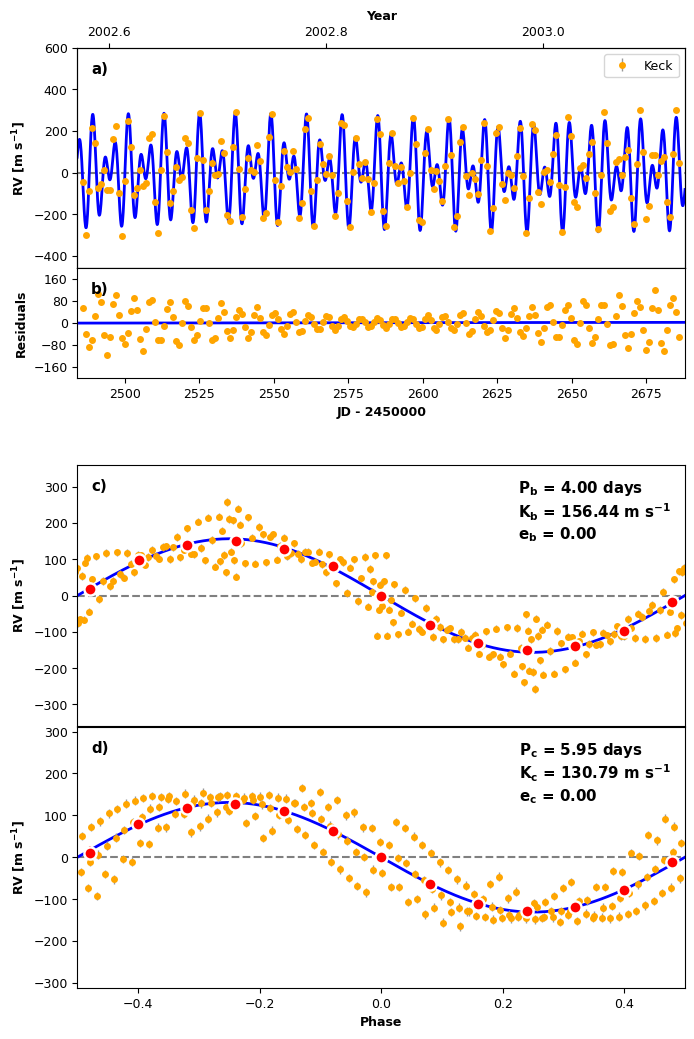

In [320]:
system_RV_obs.parameters()

In [316]:
test_cadence = cadence(system_RV_obs)
test_cadence.phase_fold()
print(test_cadence.phase_gaps())
test_cadence.JD_convert('2023A')

AttributeError: 'Target' object has no attribute 'prev_rv_jd'

In [704]:
test_cadence.cadence_optimize()

KeyboardInterrupt: 

In [618]:
phase = test_cadence.phase_fold()
phase = np.sort(phase)
distance = []
#taking the difference between two points of the phase and adding them to an array
for i in range(len(phase)): 
    #since we are subtracting from the next iteration, if the ith value is equal to the length of the 
    #phase we want to break out of the loop 
    if i == len(phase)-1: 
        break
    else: 
        diff = np.absolute(phase[i+1] - phase[i])
        distance = np.append(distance, diff)
#averaging out the distances between each of the phases
avg_distance = np.mean(distance)

#loops through the distance array and flags the phase that relates to the distance  
flagged_phase = [] 
for i in range(len(distance)): 
    #if the distance between the phases is longer than the average distance between the phases add them to 
    #a separate array and flag both of the phases 
    if distance[i] > avg_distance: 
        flagged_phase = np.append(flagged_phase, phase[i])
        flagged_phase = np.append(flagged_phase, phase[i+1])
        
for i in range(len(flagged_phase)): 
    if i == len(flagged_phase) - 1: 
        break
    if flagged_phase[i] == flagged_phase[i-1]: 
        flagged_phase = np.delete(flagged_phase, i)
print(len(phase))
print(len(flagged_phase))
print(np.array(phase))
print(" ")
print(flagged_phase)

131
40
[0.02172753 0.02206406 0.02229688 0.02251353 0.02276871 0.02430965
 0.02492671 0.02578618 0.02700941 0.03234229 0.03565253 0.08082747
 0.08134747 0.08185929 0.08455565 0.09143694 0.13832594 0.14155671
 0.14553124 0.145638   0.19558859 0.19812594 0.19855594 0.19914412
 0.19985618 0.20129829 0.20352976 0.20430876 0.20546318 0.20653794
 0.21027912 0.21488582 0.21920365 0.21973918 0.26041394 0.26484582
 0.26728782 0.26797471 0.26853341 0.31322418 0.31492741 0.32212265
 0.32270265 0.32528506 0.32726424 0.37468759 0.37490541 0.37506012
 0.37759212 0.38087747 0.38192235 0.38230024 0.38354718 0.43003882
 0.43306029 0.43360829 0.436508   0.43857247 0.44452135 0.44522224
 0.44763818 0.45016888 0.49046618 0.49465882 0.498517   0.50064524
 0.504155   0.50954506 0.54882188 0.54921635 0.55246994 0.55293735
 0.56048424 0.56066018 0.56857665 0.56891335 0.57148112 0.60845329
 0.60853106 0.61357647 0.61713794 0.61980235 0.62202176 0.62677135
 0.66602012 0.66674441 0.67296806 0.67502553 0.67529182